#### Install Python packages

Run the following package installations. **pip** is the package installer for Python. You can use pip to install packages from the Python Package Index and other indexes.
This is only required the first time, you open this workbook!

In [ ]:
!pip install hdbcli --break-system-packages
!pip install generative-ai-hub-sdk[all] --break-system-packages
!pip install folium --break-system-packages
!pip install git+https://tinyurl.com/ynnj4psz --break-system-packages
!pip install ipywidgets --break-system-packages
!pip install scikit-learn
!pip install matplotlib

In [ ]:
!pip install requests
!pip install json5

#### Restart Python kernel

The Python kernel needs to be restarted before continuing. 

> ![title](./images/config_001.png)

</br>

> **Note** This will take a couple of minutes.

#### Setup and function definitions

In [1]:
import json
import requests

This function gets an OAUTH Token whenever called.

In [2]:
def get_token(clientid, clientsecret, authurl):
    resp = requests.post(	authurl+'/oauth/token?grant_type=client_credentials',		data={}, auth=(clientid, clientsecret))
    d = json.loads(resp.text)
    return "Bearer "+d["access_token"]

Please fill in your gen AI Hub/AI Core Key details below.

In [3]:
resource_group = ""
authurl = ""
clientid = ""
clientsecret =""
api_url = ""

deployment_id_gpt4 =""
deployment_id_embedding = ""

In [22]:
# test whether the connectivity works, by requesting a token
#get_token(clientid, clientsecret, authurl)

This function sends a user and system prompt to a chat gpt model through AI Core.

In [4]:
def askGPT(messages): # role assistant, user, system
    payload = {
        "messages": [
            {
                "role": "system",
                "content": messages[0]
            },
            {
                "role": "user",
                "content": messages[1]
            }
        ]
    }
    deployment_url = api_url+f"/v2/inference/deployments/"+deployment_id_gpt4
    endpoint = f"{deployment_url}/chat/completions?api-version=2023-05-15"

    headers = {"Authorization": get_token(clientid, clientsecret, authurl), 
           "ai-resource-group": resource_group,
           "Content-Type": "application/json"}

    return requests.post(endpoint, headers=headers, json=payload)

This functions returns a vector representation of a text. We are using an ada text embedding here.

In [5]:
def embed(mystring):
    payload = {"input": mystring}
    deployment_url = api_url+f"/v2/inference/deployments/"+deployment_id_embedding
    endpoint = f"{deployment_url}/embeddings?api-version=2023-05-15"

    headers = {"Authorization": get_token(clientid, clientsecret, authurl), 
           "ai-resource-group": resource_group,
           "Content-Type": "application/json"}
    res = requests.post(endpoint, headers=headers, json=payload)
    return (res.json()['data'][0]['embedding'])

This functions formats the output in a nicer way.

In [6]:
# pretty prints a json response
def print_res(my_response):
    print(json.dumps(my_response.json(), indent=4))

In [7]:
def print_gpt(my_response):
    print(my_response.json()["choices"][0]["message"]["content"])

Now, lets do a sample call. We sent a user question and no system prompt to the gpt model and print the answer:

In [ ]:
# test gpt4
task  = "what is SAPs career starter program?"
system = ""
res = askGPT([system,task])

print_res(res)

Now we add a system message as well:

In [ ]:
# test gpt4 with system message
task  = "what is SAPs career starter program?"
system = "You are a young child. Tell the user that you are really hungry for chocolate while answering their question."

res = askGPT([system,task])

print_res(res)

Vector representations of text can be usefull to retrieve relevant information. Here we test the vector embedding:

In [ ]:
# test the embedding. output vector is truncated to 50
task  = "what is SAPs career starter program?"
res = embed(task)
print("the first 50 entries of the vector are\n", res[0:50],"\nthe vector has a total length of ",len(res))

#### Visualiziation - Understanding the embedding

Similar words/texts have similar embedding vectors.
How similar two vectors are, is calculated using the so called "cosine similarity".<br>
Lets try to understand this. First we import some libraries.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
#import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

##### (Optional) small example: Understanding cosine similarity - our distance function
This section contains some maths and can be skipped for now. (Click on the small downward pointing arrow to collapse the section.)
Return here later to get a better understanding.

In [ ]:
vector_example = [
[1,0], [0,1],[0.5,0.5]
]

norm = np.linalg.norm(vector_example[2])
vector_example[2] = [0.5 / norm, 0.5 / norm]
vectors = np.array(vector_example)

cs = cosine_similarity(vector_example,vector_example)
print(cs)

plot vectors

In [ ]:
# Plot the vectors
plt.figure(figsize=(6, 6))
origin = np.zeros((2, len(vectors)))  # origin point

# Plot each vector
for vec, color in zip(vectors, ['r', 'g', 'b']):
    plt.quiver(*origin, vec[0], vec[1], color=color, scale=1, scale_units='xy', angles='xy')

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.grid()
plt.title('Plot of Example Vectors')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
print("90 degree corresponds to pi/2 = ", np.pi/2)
print("45 degree corresponds to pi/4 = ", np.pi/4)
np.arccos(cs)

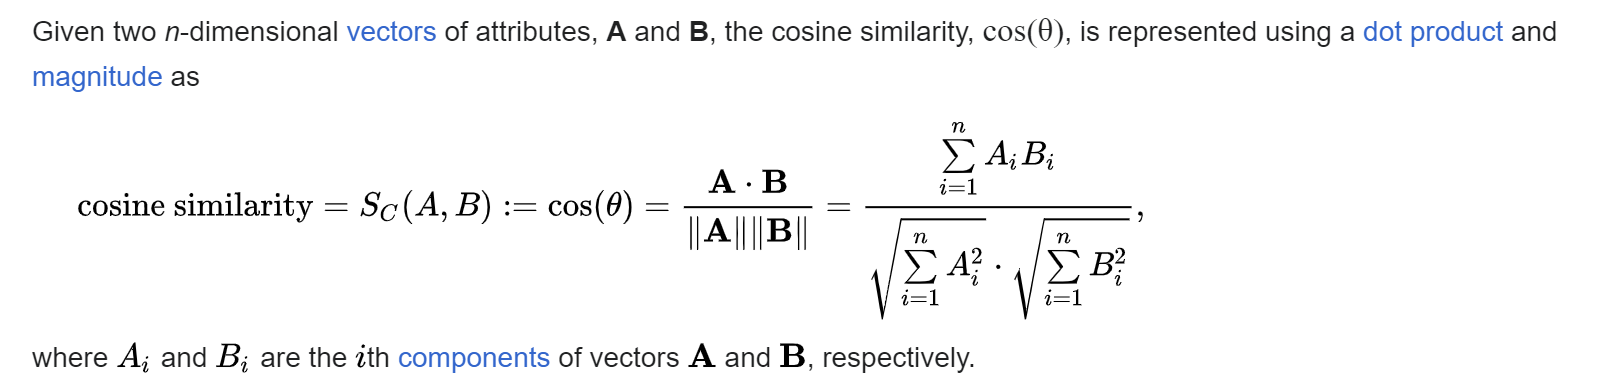

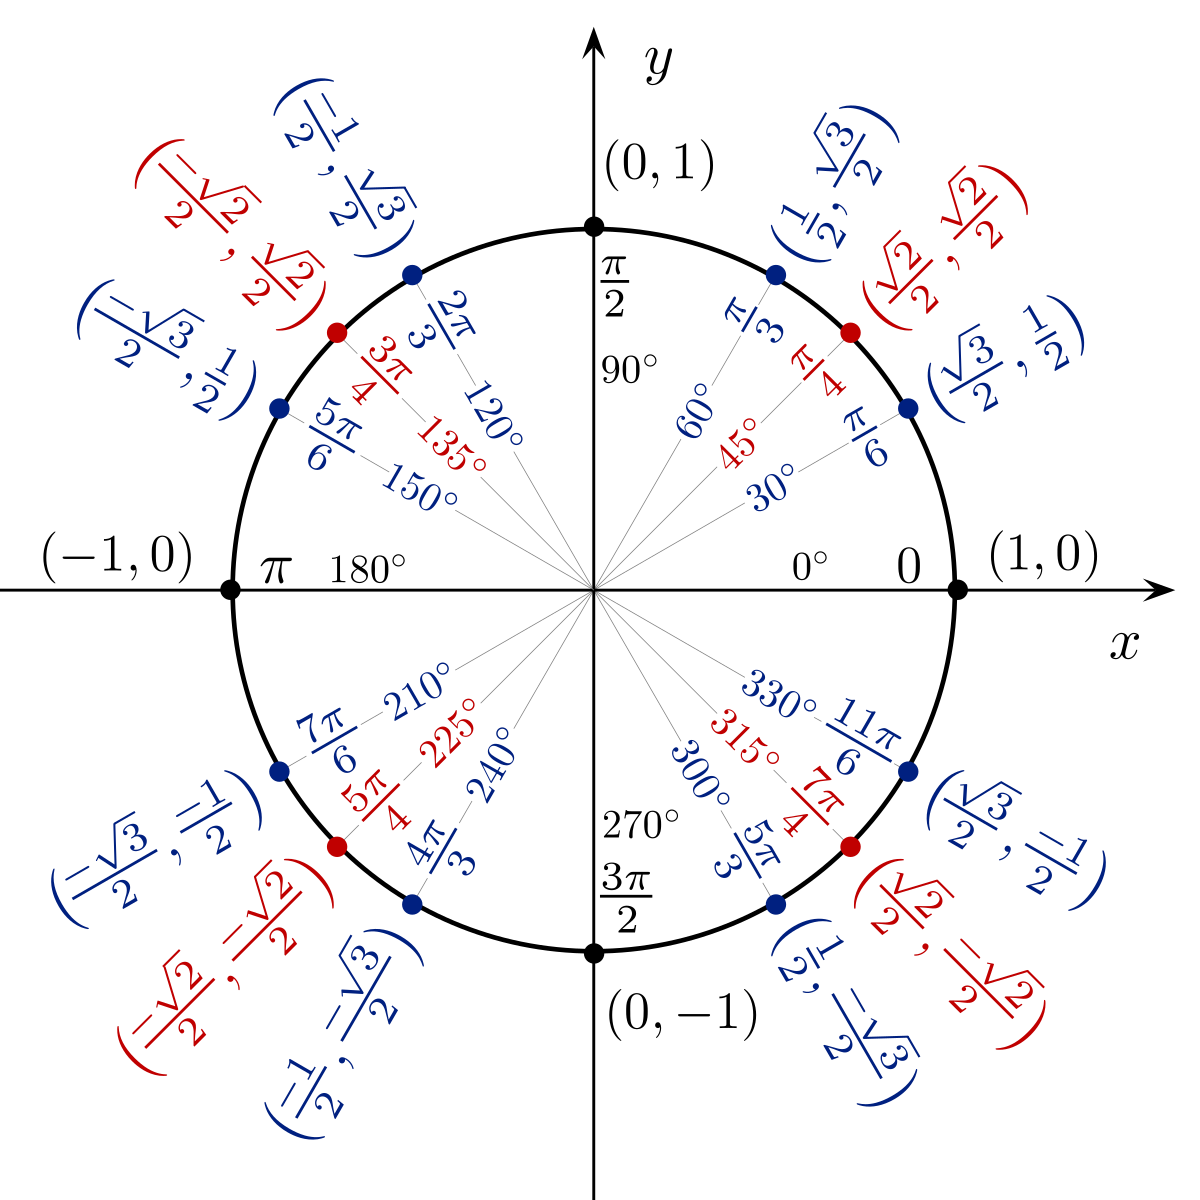

##### Define cosine similarity helper function
Writing a program to tell us that "king" and "queen" have a related meaning, is very difficult.
We use the embedding function to help us with this. Similar words have similar vectors (if the embedding is good).
The *cosine similarity* allows us to describe how similar two vectors are - think of comparing the angle between two vectors.
Define a function to compute this for us and visualize it:

In [24]:
def cosineSim(df,texts):
    data= cosine_similarity(df, df)
    fig, ax = plt.subplots()
    im = ax.imshow(data)
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(texts)))
    ax.set_yticks(np.arange(len(texts)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(texts)
    ax.set_yticklabels(texts)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(texts)):
        for j in range(len(texts)):
            text = ax.text(j, i, str(data[i, j])[0:4],
                           ha="center", va="center", color="w")

    ax.set_title("Cosine Similarity")
    fig.tight_layout()
    plt.show()

We test the embedding by sending a list of words. Try to understand and validate the returned matrix.
High values close to 1 mean high similarity. The lower the number, the less similarity. The values range from 0 to 1.

In [ ]:
texts = ["Woman","Man","King","Queen", "Pizza","Apple","Microsoft","Google","BMW"]
vec_list = [ embed(a) for a in texts]
cosineSim(vec_list,texts)

### Knowledge database

We are now able to find similar text for a user entered question.
Let us build a knowledge database that can be used to answer questions.

The folder "texts" contains a few text files, which we will consider. Feel free to add additional text files.

In [26]:
from os import listdir
from os.path import isfile, join
from pathlib import Path
mypath = "texts"

In [27]:
mydict = {}
for f in listdir(mypath):
    mydict[Path(f).stem] = {"file":mypath+"/"+f }

We automatically consider every file in the text folder. Let us see what was found:

In [ ]:
mydict

Now, we embed every file to get a vector representation.

In [29]:
for a in mydict:
    with open(mydict[a]["file"], encoding="utf8") as f:
        data = f.read()
        mydict[a]["content"]= data
        #data=data[0:8190]
        mydict[a]["vector"] = embed(data)

In [ ]:
mydict.keys()

Let us print the matrix to see how similar the text sources are to each other:

In [ ]:
cosineSim(  [ mydict[a]["vector"]  for a in mydict], [ a for a in mydict])

### Find similar sources

We define a new function that takes the dictionary as knowledge database and a user entered text as input.
The function then returns the n most similar texts.

In [73]:
def similiar_sources(dictionary, mytext, top_n):
        df =  [ dictionary[a]["vector"] for a in dictionary]
        df = df + [embed(mytext)]
        similarity_matrix= cosine_similarity(df, df)
        # Get the last vector's similarities with all other vectors
        last_vector_similarities = similarity_matrix[-1]
        
        # Exclude the similarity with itself by setting it to -1
        last_vector_similarities[-1] = -np.inf
    
        # Find the index of the most similar vector
        most_similar_index = np.argmax(last_vector_similarities)
        top_n_indices = np.argsort(last_vector_similarities)[-top_n:][::-1]
        return  [list(mydict.keys())[i] for i in top_n_indices]
        # Get the corresponding file name
        # return list(mydict.keys())[most_similar_index]

Let us test the function.

In [ ]:
sim_sources = similiar_sources(mydict, "gibt es neue artikel zur wasserknappheit?", 2)
print(sim_sources)

In [ ]:
# show the content for the idenfitied sources
[mydict[a]["content"] for a in sim_sources]

### Build Prompt

Idea: Given a user entered question, fetch the similar sources from the knowledge database using the function *similiar_sources*.

Now build a prompt by adding the identified sources to the question and sent it to the large language model.

In [76]:
def build_prompt(question, sim_sources):
    nl = "\n"
    divider = "-" * 80
    prompt = ""
    prompt += nl + divider + nl
    prompt += "Question: "
    prompt += question
    prompt += nl + divider + nl
    prompt += "Sources:"""
    for doc in sim_sources:
        prompt += nl + divider + nl
        prompt += mydict[doc]["content"]
        
    prompt += nl + divider + nl
    return prompt
    

Show an example for such a prompt:

In [ ]:
question = "are there updates on water shortages? "
sim_sources = similiar_sources(mydict, question,2)
# show what the prompt looks like
build_prompt(question, sim_sources)

### Ask GPT

We tell GPT to use the provided sources to answer the question.
Finally, we combine all the different ingredients:

In [78]:
instructions = "Please only use the provided sources to answer the questions. If possible also specify the regions mentioned in the sources."

#### Example 1

In [80]:
question = "are there updates on water shortages? "
sim_sources = similiar_sources(mydict, question,2)
prompt = build_prompt(question, sim_sources)

In [ ]:
res = askGPT([instructions,prompt])
print_res(res)

#### Example 2

In [ ]:
question = "Create a list of the most important topics in Sapphire."
sim_sources = similiar_sources(mydict, question,2)
prompt = build_prompt(question, sim_sources)

res = askGPT([instructions,prompt])
print_gpt(res)
